Epoch [10/10], Loss: 0.5546, Accuracy: 0.9870


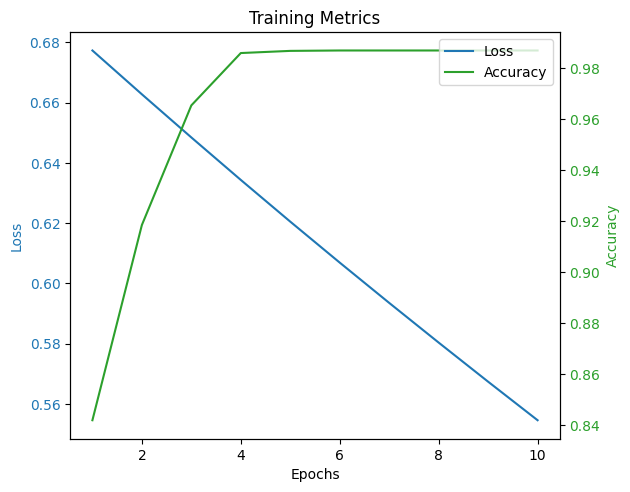

Accuracy: 0.9880


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load the dataset
data = pd.read_csv('../simulation_results.csv')

# Features and target variable
features = data[['votesA', 'votesB', 'area', 'perimeter', 'pp_compactness', 'eg', 'win_count_a', 'win_count_b', 'total_votes']]
target = data['imp_flag']

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the neural network
class GerrymanderingNN(nn.Module):
    def __init__(self):
        super(GerrymanderingNN, self).__init__()
        self.layer1 = nn.Linear(9, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

# Instantiate the model, define the loss function and the optimizer
model = GerrymanderingNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
metrics = {'loss': [], 'accuracy': []}

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred_class = y_pred.round()
        accuracy = (y_pred_class.eq(y_train).sum().float() / y_train.shape[0]).item()
    
    # Store metrics
    metrics['loss'].append(loss.item())
    metrics['accuracy'].append(accuracy)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

plot_metrics(metrics)
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test).sum().float() / y_test.shape[0]).item()
    print(f'Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'gerrymandering_model.pth')


In [18]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    """
    Plots the key metrics such as loss and accuracy.

    Parameters:
    - metrics (dict): A dictionary containing lists of metrics to plot. Keys should include 'loss' and 'accuracy'.
    """
    epochs = range(1, len(metrics['loss']) + 1)

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, metrics['loss'], color=color, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, metrics['accuracy'], color=color, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Training Metrics')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()
